In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from spike_statistics.core import permutation_resampling

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot

19:14:03 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / "stimulus-spike-lfp-response"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [6]:
lfp_action = actions['stimulus-spike-lfp-response']
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [7]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
lfp_results = lfp_results.drop('unit_id', axis=1)

In [8]:
statistics_action = actions['calculate-statistics']
shuffling = actions['shuffling']

statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics_results = session_units.merge(statistics_results, how='left')
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics_results, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [9]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [10]:
data = data.merge(lfp_results, how='left')

In [11]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

In [12]:
data = data.merge(waveform_results, how='left')

In [13]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and Hz11', 'frequency==11', 'baseline and Hz30', 'frequency==30']

In [14]:
data.bs = data.bs.astype(bool)

In [15]:
grid_query = 'gridness > gridness_threshold and information_rate > information_rate_threshold'
sessions_above_threshold = data.query(grid_query)
print("Number of gridcells", len(sessions_above_threshold))
# print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of gridcells 225


In [16]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]

In [17]:
gridcell_sessions

action  baseline  entity  frequency      i     ii  session  \
17    1839-120619-4     False    1839       30.0  False   True        4   
19    1839-120619-4     False    1839       30.0  False   True        4   
21    1839-120619-4     False    1839       30.0  False   True        4   
29    1839-120619-4     False    1839       30.0  False   True        4   
30    1839-120619-4     False    1839       30.0  False   True        4   
31    1839-120619-4     False    1839       30.0  False   True        4   
33    1833-260619-1      True    1833        NaN   True  False        1   
34    1833-260619-1      True    1833        NaN   True  False        1   
35    1833-260619-1      True    1833        NaN   True  False        1   
39    1833-260619-1      True    1833        NaN   True  False        1   
40    1833-260619-1      True    1833        NaN   True  False        1   
42    1833-260619-1      True    1833        NaN   True  False        1   
44    1833-260619-1      True    1833        NaN   True  False        1   
46    1833-260619-1      True    1833        NaN   True  False        1   
47    1833-260619-1      True    1833        NaN   True  False        1   
49    1833-260619-1      True    1833        NaN   True  False        1   
54    1839-060619-3     False    1839       11.0   True  False        3   
57    1834-150319-3      True    1834        NaN  False   True        3   
76    1834-120319-4     False    1834       30.0  False   True        4   
87    1849-280219-4     False    1849       30.0  False   True        4   
106   1849-110319-2     False    1849       11.0   True  False        2   
124   1833-010719-1      True    1833        NaN   True  False        1   
125   1833-010719-1      True    1833        NaN   True  False        1   
126   1833-010719-1      True    1833        NaN   True  False        1   
128   1833-010719-1      True    1833        NaN   True  False        1   
129   1833-010719-1      True    1833        NaN   True  False        1   
131   1833-010719-1      True    1833        NaN   True  False        1   
132   1833-010719-1      True    1833        NaN   True  False        1   
134   1833-010719-1      True    1833        NaN   True  False        1   
135   1833-010719-1      True    1833        NaN   True  False        1   
...             ...       ...     ...        ...    ...    ...      ...   
1154  1839-120619-3      True    1839        NaN  False   True        3   
1155  1834-110319-5     False    1834       11.0   True  False        5   
1156  1834-110319-5     False    1834       11.0   True  False        5   
1174  1839-200619-2     False    1839       11.0   True  False        2   
1184  1833-260619-3      True    1833        NaN  False   True        3   
1185  1833-260619-3      True    1833        NaN  False   True        3   
1186  1833-260619-3      True    1833        NaN  False   True        3   
1189  1833-260619-3      True    1833        NaN  False   True        3   
1191  1833-260619-3      True    1833        NaN  False   True        3   
1193  1833-260619-3      True    1833        NaN  False   True        3   
1194  1833-260619-3      True    1833        NaN  False   True        3   
1197  1833-260619-3      True    1833        NaN  False   True        3   
1199  1833-260619-3      True    1833        NaN  False   True        3   
1202  1833-260619-3      True    1833        NaN  False   True        3   
1204  1833-260619-3      True    1833        NaN  False   True        3   
1208  1833-200619-3      True    1833        NaN  False   True        3   
1214  1833-200619-3      True    1833        NaN  False   True        3   
1215  1833-200619-3      True    1833        NaN  False   True        3   
1217  1833-200619-3      True    1833        NaN  False   True        3   
1218  1833-200619-3      True    1833        NaN  False   True        3   
1219  1833-200619-3      True    1833        NaN  False   True        3   
1220  1833-200619-3      True    1833 

In [18]:
data.loc[:,'gridcell'] = False
data['gridcell'] = data.isin(gridcell_sessions)

In [19]:
data.query('baseline and Hz11 and gridcell').head()

action  baseline  entity  frequency     i     ii  session  \
33  1833-260619-1      True    1833        NaN  True  False        1   
34  1833-260619-1      True    1833        NaN  True  False        1   
35  1833-260619-1      True    1833        NaN  True  False        1   
39  1833-260619-1      True    1833        NaN  True  False        1   
40  1833-260619-1      True    1833        NaN  True  False        1   

   stim_location  stimulated         tag  ...  stim_half_f2 stim_half_width  \
33           NaN       False  baseline i  ...           NaN             NaN   
34           NaN       False  baseline i  ...           NaN             NaN   
35           NaN       False  baseline i  ...           NaN             NaN   
39           NaN       False  baseline i  ...           NaN             NaN   
40           NaN       False  baseline i  ...           NaN             NaN   

    stim_energy  half_width  peak_to_trough  average_firing_rate     bs  \
33          NaN    0.272875        0.602667             5.945508   True   
34          NaN    0.226452        0.274814             2.860048  False   
35          NaN    0.247266        0.570104             3.365674   True   
39          NaN    0.284542        0.644111            17.471520   True   
40          NaN    0.259920        0.581698             5.891739   True   

   bs_stim  bs_ctrl  gridcell  
33     NaN      1.0      True  
34     NaN      0.0      True  
35     NaN      1.0      True  
39     NaN      1.0      True  
40     NaN      1.0      True  

[5 rows x 68 columns]

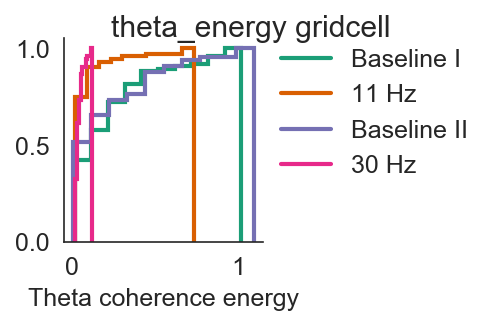

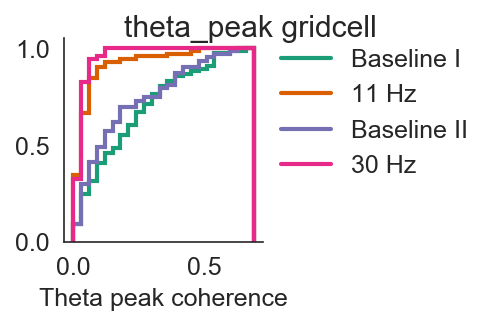

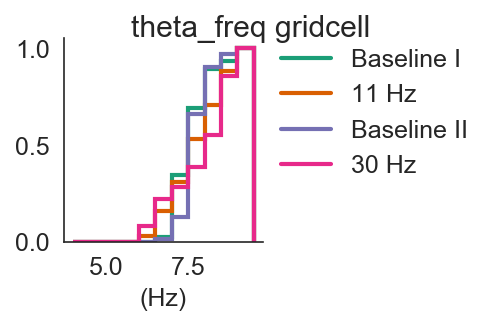

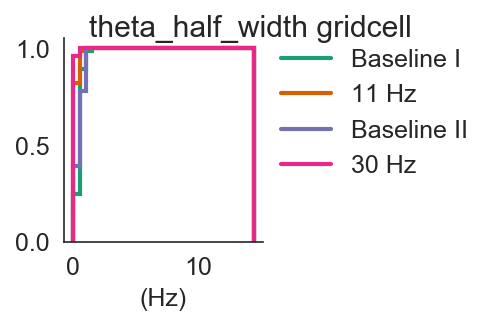

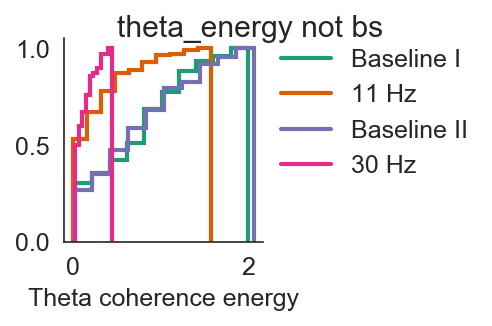

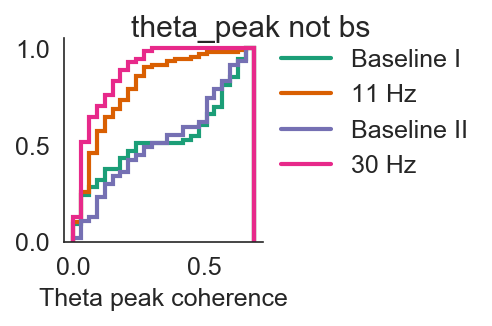

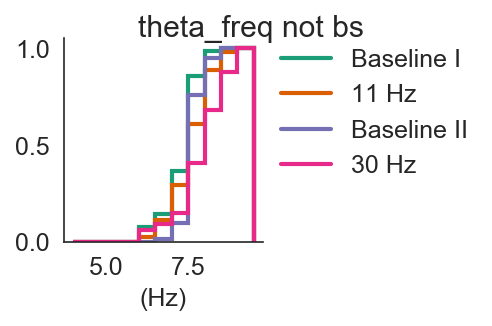

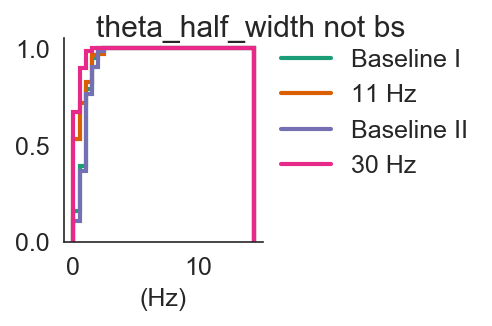

In [21]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'theta_energy': None,#np.arange(0, .7, .03),
    'theta_peak': np.arange(0, .7, .03),
    'theta_freq': np.arange(4, 10, .5),
    'theta_half_width': np.arange(0, 15, .5)
}
xlabel = {
    'theta_energy': 'Theta coherence energy',
    'theta_peak': 'Theta peak coherence',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
}

for cell_type in ['gridcell', 'not bs']:
    for key in bins:
        fig = plt.figure(figsize=(3.5,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            data.query(query + ' and ' + cell_type)[key].hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
#         plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        sns.despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [22]:
data['stim_strength'] = data.stim_p_max / data.theta_energy

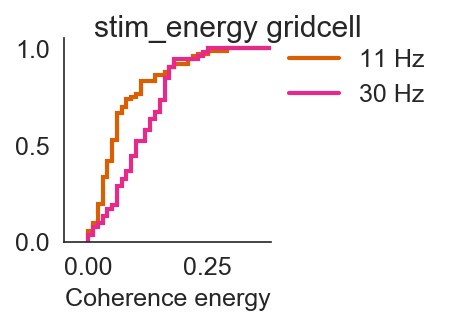

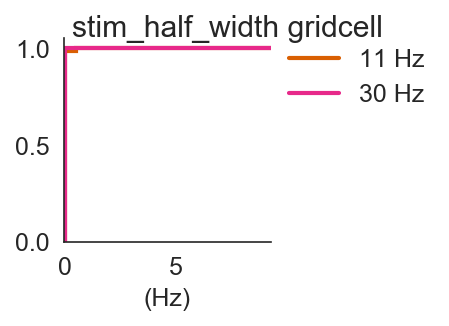

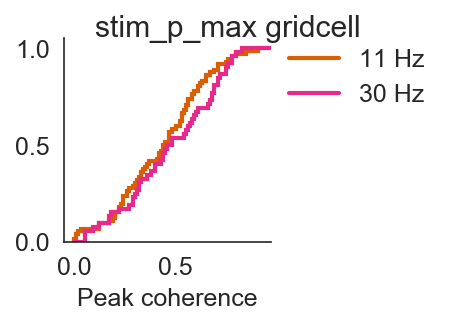

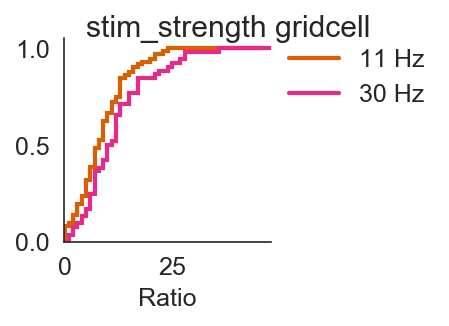

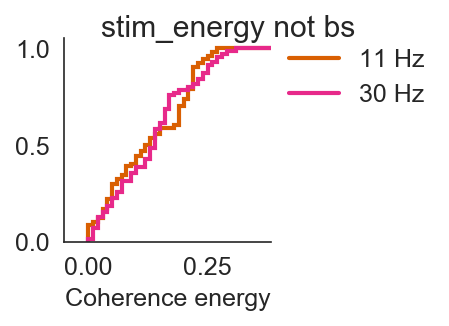

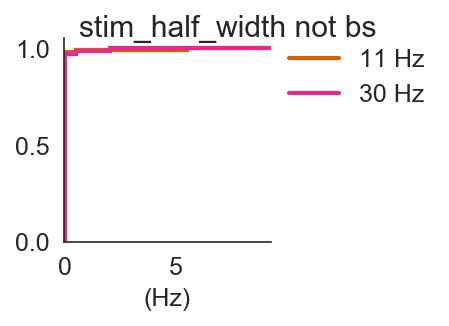

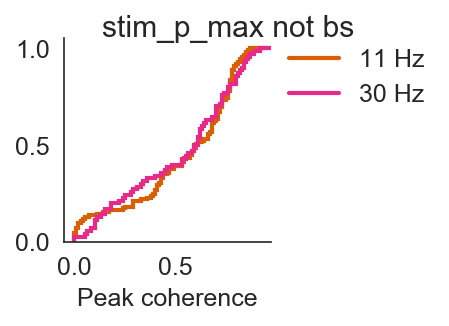

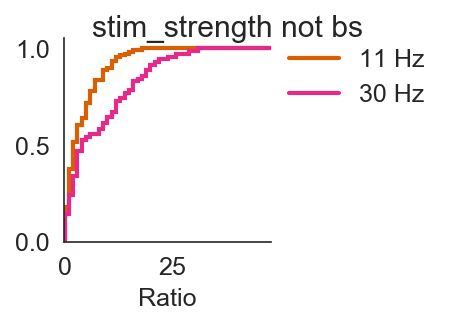

In [23]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'stim_energy': np.arange(0, .4, .01),
    'stim_half_width': np.arange(0, 10, .5),
    'stim_p_max': np.arange(0, 1, .01),
    'stim_strength': np.arange(0, 50, 1)
}
xlabel = {
    'stim_energy': 'Coherence energy',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak coherence',
    'stim_strength': 'Ratio',
}
# key = 'theta_energy'
# key = 'theta_peak'
for cell_type in ['gridcell', 'not bs']:
    for key in bins:
        fig = plt.figure(figsize=(3.2,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors[1::2], queries[1::2], labels[1::2]):
            data.query(query + ' and ' + cell_type)[key].hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        sns.despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [24]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [25]:
coher = pd.read_feather(output_path / 'data' / 'coherence.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [26]:
freq = freqs.T.iloc[0].values

mask = (freq < 100)

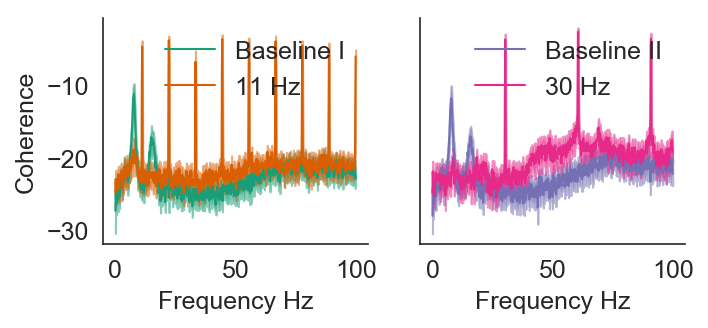

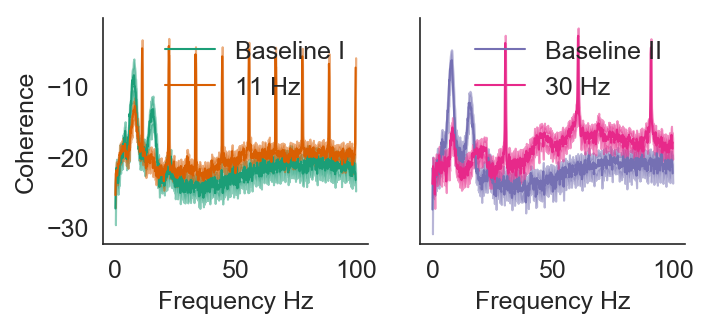

In [27]:
for cell_type in ['gridcell', 'not bs']:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
    axs = axs.repeat(2)
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = coher.loc[mask, selection].dropna(axis=1).to_numpy()
        values = 10 * np.log10(values)
        plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
    #     ax.set_title(titles[i])
        ax.set_xlabel('Frequency Hz')
        ax.legend(frameon=False)
    axs[0].set_ylabel('Coherence')
    sns.despine()
    figname = f'spike-lfp-coherence-{cell_type}'.replace(' ', '-')
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [28]:
action = project.require_action("stimulus-spike-lfp-response")

In [29]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/data/freqs.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/data/coherence.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-stim_strength-not-bs.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-stim_energy-not-bs.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-theta_peak-gridcell.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-theta_energy-gridcell.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-not-bs.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-stim_ener

In [30]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-spike-lfp-response.ipynb")